In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [2]:
tickers = [
    "VTI", "VWO", "VEA", "BND", "NVDA", "TSLA", "AAPL", "GOOGL",
    "LMT", "RMBS", "PLTR", "MSFT", "PEP", "AVGO", "SOFI", "OKLO", "QSI"
]

df = yf.download(tickers, period="1y")["Close"]
df.head()


/var/folders/xm/pjfr6m5d7b3bfhc_bfrghpwh0000gn/T/ipykernel_18903/2496332617.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, period="1y")["Close"]
[*********************100%***********************]  17 of 17 completed


Ticker            AAPL        AVGO        BND       GOOGL         LMT  \
Date                                                                    
2024-10-23  229.691010  171.824783  70.431038  162.065292  555.474976   
2024-10-24  229.501892  169.685760  70.546501  162.005554  548.773499   
2024-10-25  230.338013  171.319733  70.402145  164.544373  546.905945   
2024-10-28  232.318771  170.349274  70.315552  165.987991  539.980774   
2024-10-29  232.587524  177.499130  70.373299  168.934967  531.839722   

Ticker            MSFT        NVDA       OKLO         PEP       PLTR    QSI  \
Date                                                                          
2024-10-23  421.436066  139.519989  18.299999  166.513062  42.590000  0.792   
2024-10-24  421.565094  140.369751  18.059999  165.752457  43.560001  0.776   
2024-10-25  424.959595  141.499420  19.110001  165.396210  44.860001  0.745   
2024-10-28  423.411224  140.479736  24.500000  163.518784  44.970001  0.770   
2024-10-29  428.731293  141.209503  24.840000  161.265884  44.930000  0.771   

Ticker           RMBS   SOFI        TSLA        VEA         VTI        VWO  
Date                                                                        
2024-10-23  41.400002  10.42  213.649994  48.890854  281.505157  45.602985  
2024-10-24  42.040001  10.93  260.480011  49.065151  282.255737  45.554600  
2024-10-25  43.500000  10.99  269.190002  48.910221  281.989075  45.515896  
2024-10-28  44.799999  11.19  262.510010  49.268505  283.134674  45.661037  
2024-10-29  51.000000  10.47  259.519989  49.103886  283.509918  45.486870

In [3]:
returns = np.log(df / df.shift(1)).dropna()

# Asset-level mean and covariance
mu = returns.mean().values
cov = returns.cov().values

# Simulation parameters
dt = 1/252         # daily timestep
n_assets = len(tickers)
n_steps = 200      # forecast horizon in days
n_sims = 10000     # Monte Carlo paths
S0 = df.iloc[-1].values  # last observed prices

# Cholesky decomposition for correlated random shocks
L = np.linalg.cholesky(cov)



In [4]:
output = np.zeros((n_sims, n_steps, n_assets))  # simulated prices

for i in range(n_sims):
    S = S0.copy()
    for t in range(n_steps):
        Z = np.random.normal(size=n_assets)
        vol = np.sqrt(np.diag(cov))  # vector of std devs
        correlated_Z = np.dot(L, Z)  # correlated normals with unit variance
        S = S * np.exp((mu - 0.5 * vol**2) * dt + (correlated_Z.T * vol).T * np.sqrt(dt))
        output[i, t, :] = S

# Compute asset-level returns over the horizon
sim_asset_returns = output[:, -1, :] / output[:, 0, :] - 1
print("sim_asset_returns shape:", sim_asset_returns.shape)


sim_asset_returns shape: (10000, 17)


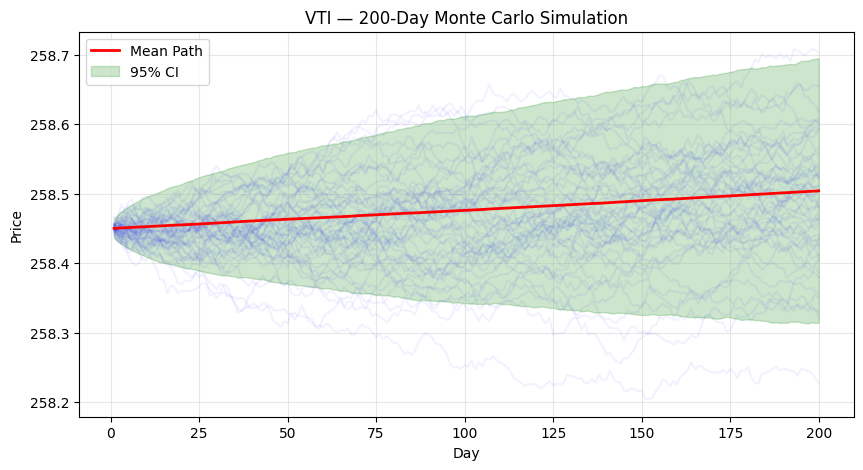

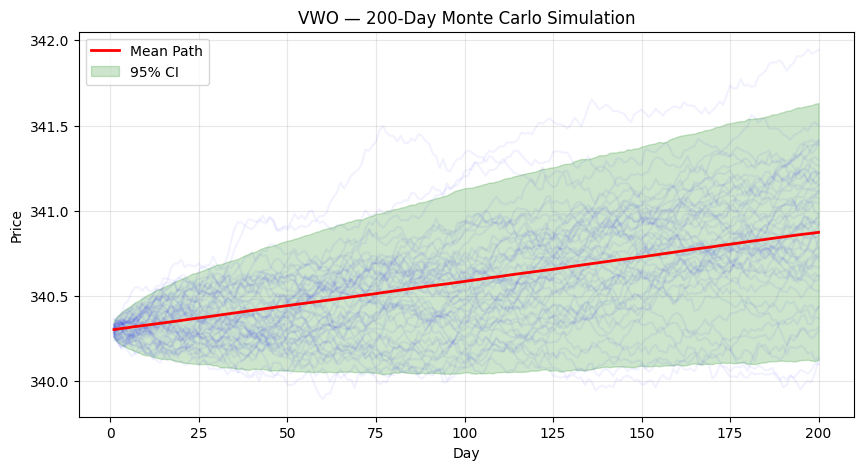

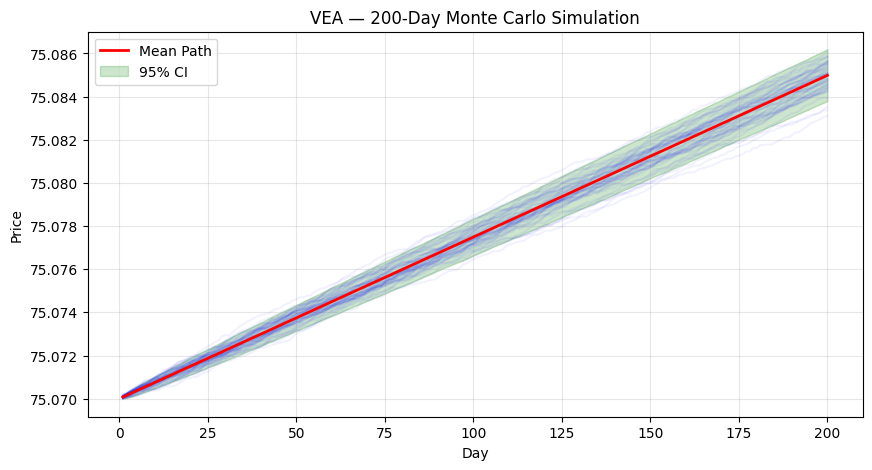

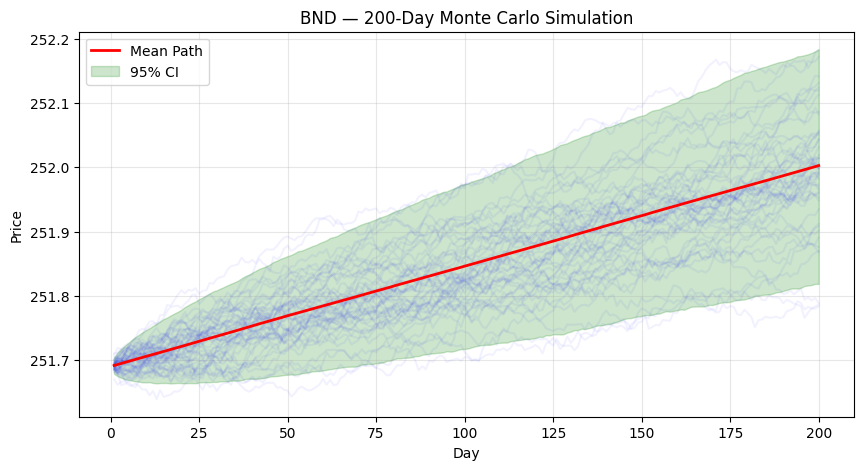

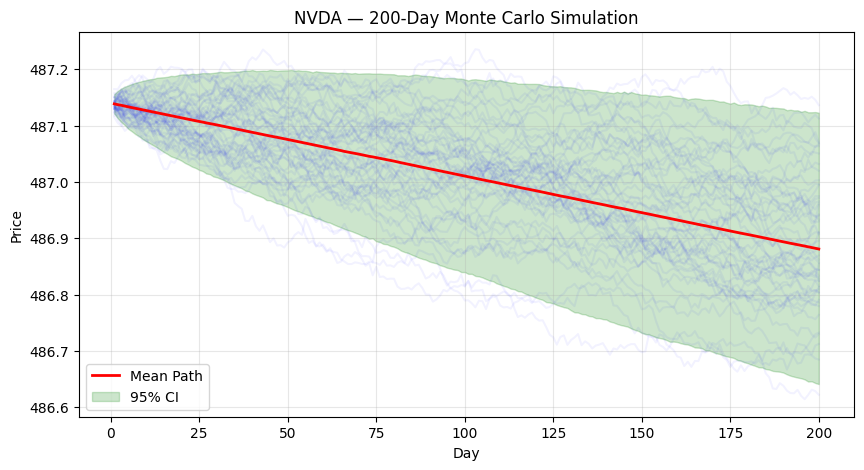

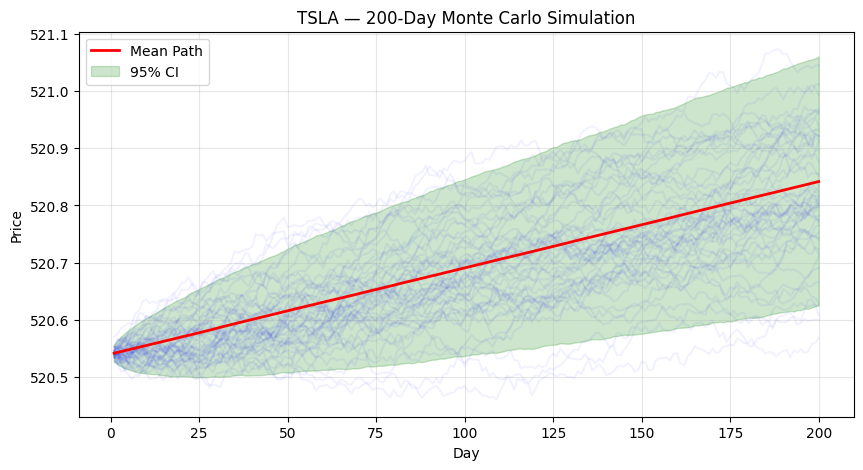

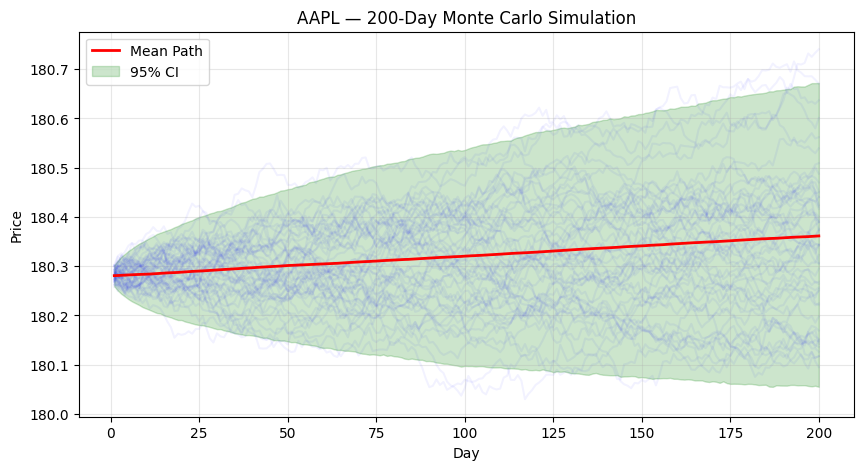

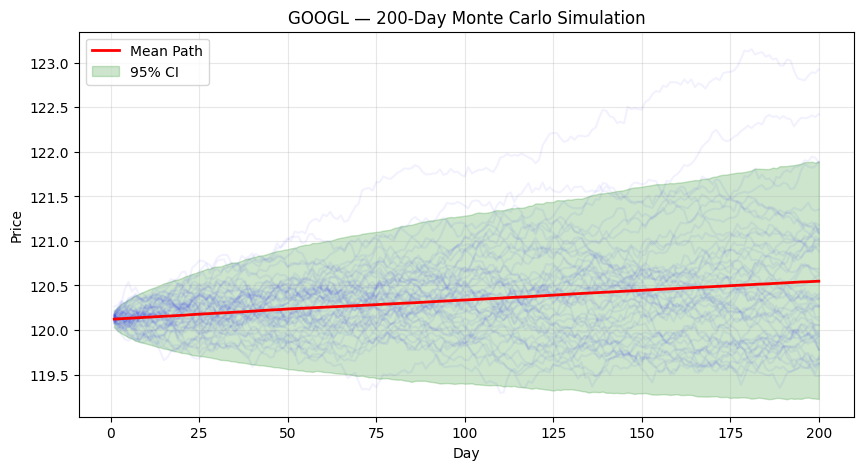

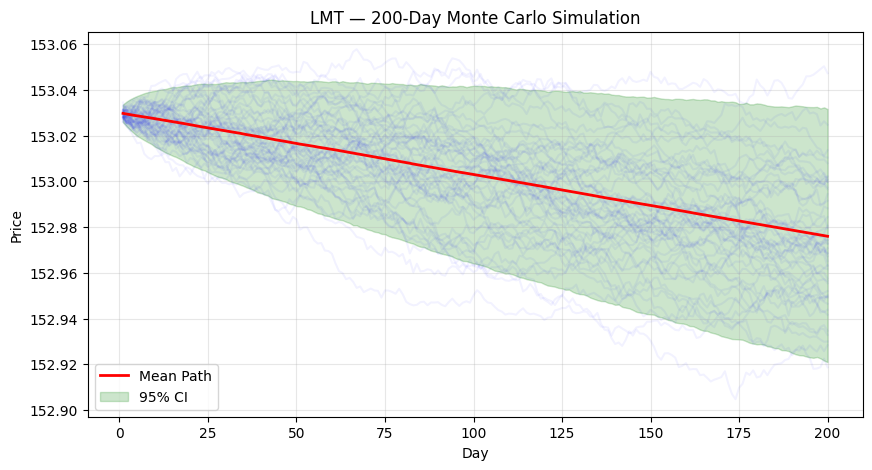

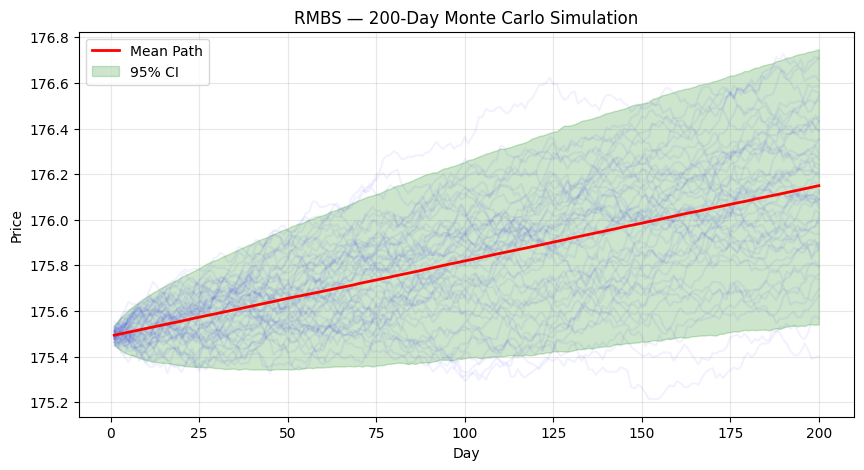

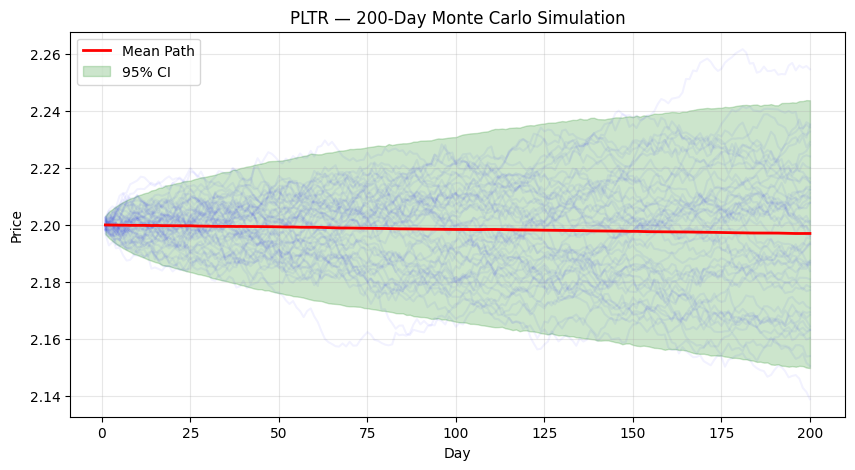

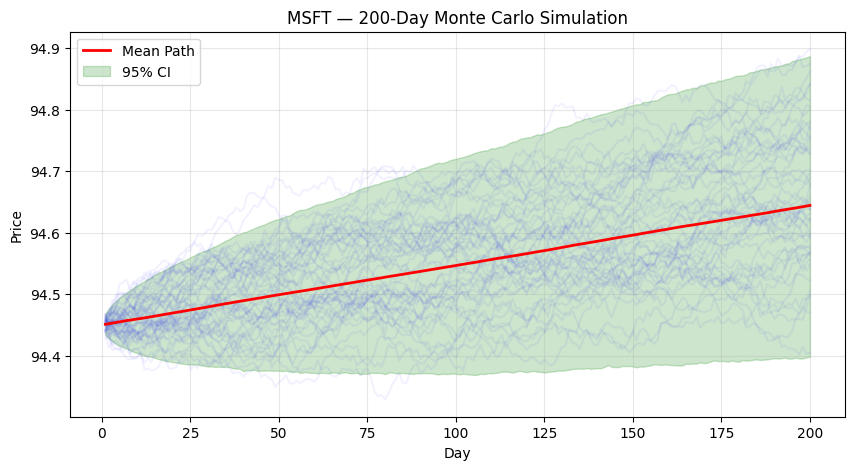

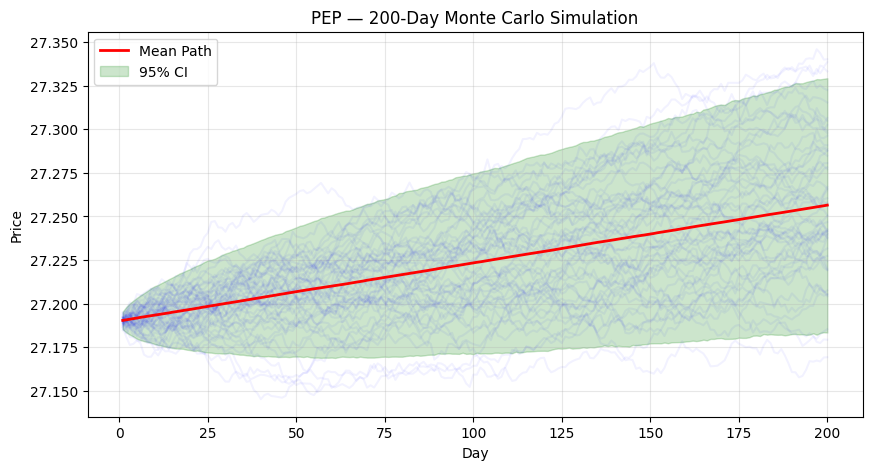

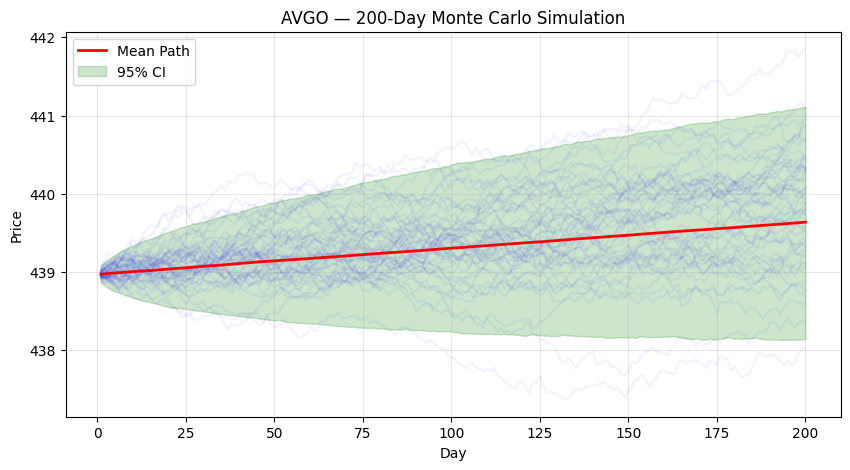

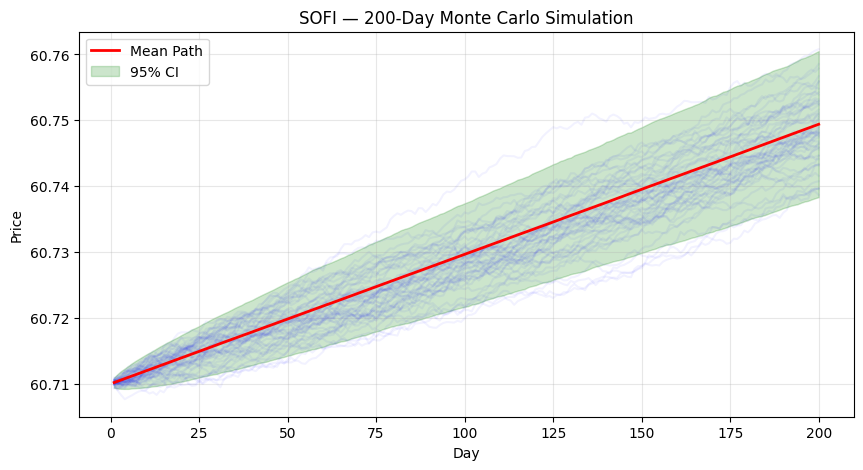

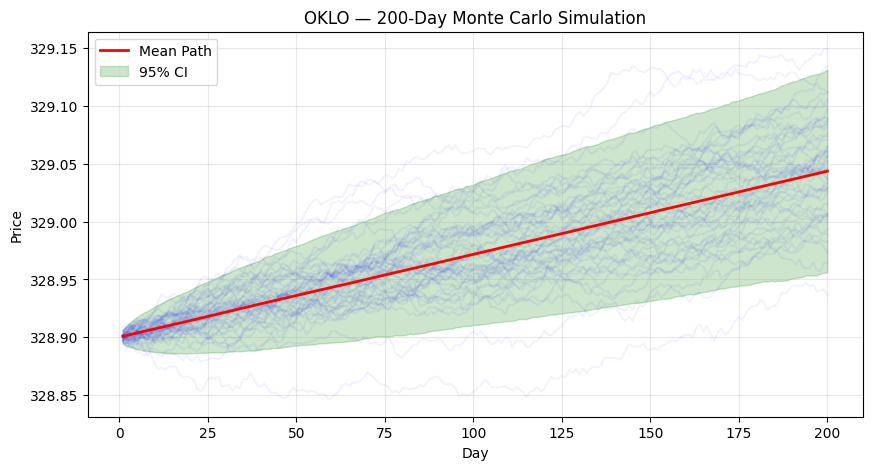

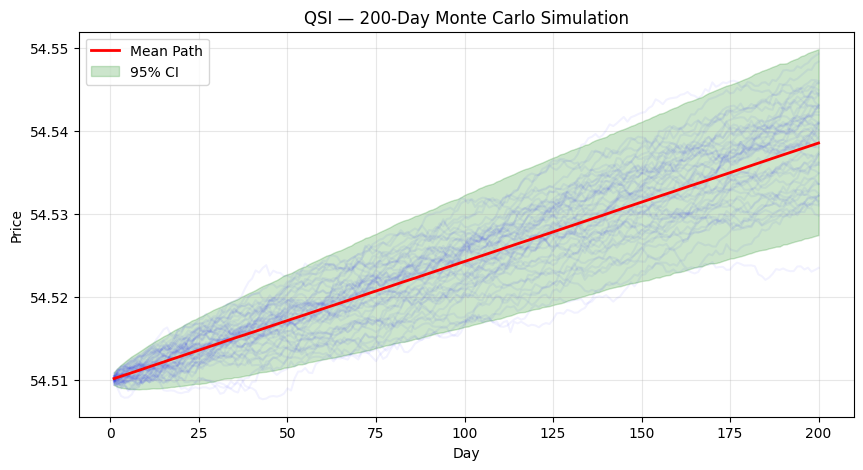

In [5]:
time = np.arange(1, n_steps + 1)

for idx, ticker in enumerate(tickers):
    plt.figure(figsize=(10, 5))

    # Plot 50 random sample paths for clarity
    for path in np.random.choice(np.arange(n_sims), size=50, replace=False):
        plt.plot(time, output[path, :, idx], color='blue', alpha=0.05)

    # Plot mean path
    mean_path = output[:, :, idx].mean(axis=0)
    plt.plot(time, mean_path, color='red', linewidth=2, label='Mean Path')

    # Plot 95% confidence interval
    p_lower = np.percentile(output[:, :, idx], 2.5, axis=0)
    p_upper = np.percentile(output[:, :, idx], 97.5, axis=0)
    plt.fill_between(time, p_lower, p_upper, color='green', alpha=0.2, label='95% CI')

    # Labels and grid
    plt.title(f"{ticker} — 200-Day Monte Carlo Simulation")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


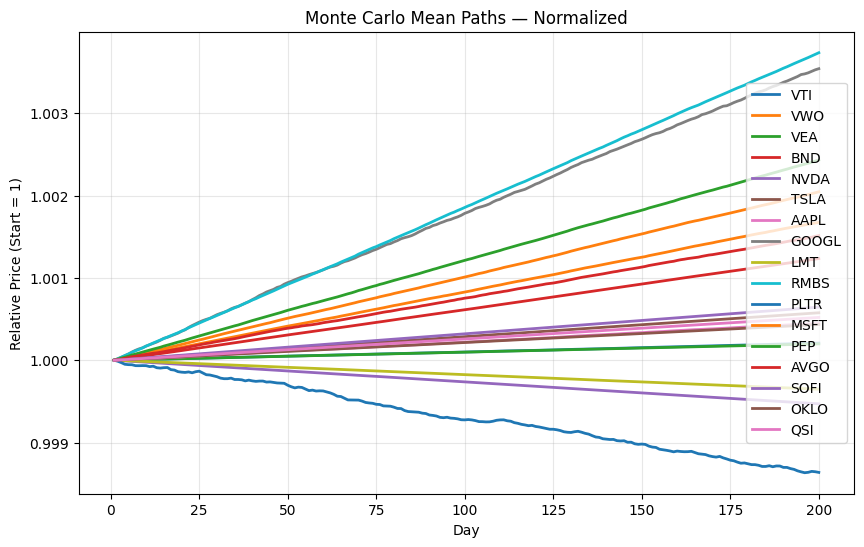

In [6]:
plt.figure(figsize=(10, 6))
for idx, ticker in enumerate(tickers):
    mean_path = output[:, :, idx].mean(axis=0)
    normalized = mean_path / mean_path[0]  # normalize to 1 at start
    plt.plot(time, normalized, linewidth=2, label=ticker)

plt.title("Monte Carlo Mean Paths — Normalized")
plt.xlabel("Day")
plt.ylabel("Relative Price (Start = 1)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [18]:
weights = np.random.rand(n_assets)
weights /= weights.sum()  # normalize to sum=1

portfolio_values = np.sum(output * weights, axis=2)
final_returns = portfolio_values[:, -1] / portfolio_values[:, 0] - 1
alpha = 5
rf = 0.0355/252

VaR_95 = np.percentile(final_returns, 5)
CVaR_5 = final_returns[final_returns <= VaR_95].mean()
sharpe = (final_returns.mean() - rf) / final_returns.std()
print(f"Portfolio Sharpe Ratio: {sharpe:.2f}")
print("Random portfolio 5% VaR:", VaR_95)
print("Random portfolio 5% CVaR:", CVaR_5)

Portfolio Sharpe Ratio: 1.19
Random portfolio 5% VaR: -0.00011750470173415012
Random portfolio 5% CVaR: -0.00034882125743165295


In [19]:
def portfolio_var(weights, returns, alpha=5):
    """
    Compute portfolio VaR (5%) for a given set of weights.
    Returns negative VaR since we minimize for optimization.
    """
    portfolio_returns = returns @ weights
    var = np.percentile(portfolio_returns, alpha)
    return -var

# Constraints: weights sum to 1, weights >= 0
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
bounds = [(0, 1) for _ in range(n_assets)]

initial_weights = np.ones(n_assets) / n_assets
result = minimize(portfolio_var, initial_weights, args=(sim_asset_returns,), bounds=bounds, constraints=constraints)

optimal_weights = result.x

print("Optimal weights (min VaR):", optimal_weights)
print("Optimal portfolio VaR:", round(-result.fun * 100, 4), "%")
print("Sum of weights:", optimal_weights.sum())
print("Weight range:", optimal_weights.min(), "-", optimal_weights.max())

Optimal weights (min VaR): [8.89849502e-03 1.70129331e-01 4.27820736e-02 9.86016343e-02
 0.00000000e+00 6.76318483e-02 2.40415961e-16 2.05076333e-02
 0.00000000e+00 1.45929862e-01 2.04619889e-17 1.16381506e-01
 1.23254025e-01 1.08432881e-03 8.42752632e-02 5.01061924e-02
 7.04178062e-02]
Optimal portfolio VaR: 0.0533 %
Sum of weights: 1.0000000000000002
Weight range: 0.0 - 0.17012933139391415


Portfolio Sharpe Ratio: 2.20
Portfolio 5% VaR: 0.0005326202624085168
CVaR 5% (Monte Carlo): 0.02%
Portfolio Mean Return: 0.0017265889444466988
Portfolio Std Dev: 0.0007215493935480217


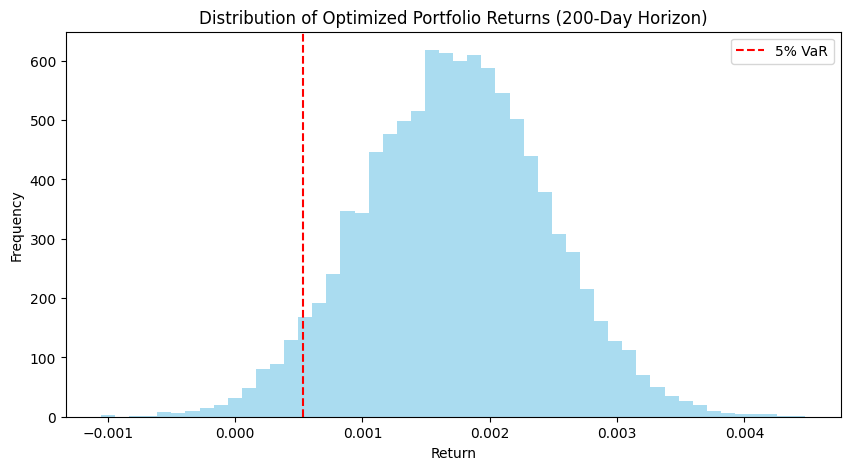

In [20]:
port_ret = sim_asset_returns @ optimal_weights
sharpe = (port_ret.mean()- rf) / port_ret.std()

print(f"Portfolio Sharpe Ratio: {sharpe:.2f}")
print("Portfolio 5% VaR:", np.percentile(port_ret, 5))
print(f"CVaR 5% (Monte Carlo): {port_ret[port_ret <=  np.percentile(port_ret, 5)].mean()*100:.2f}%")
print("Portfolio Mean Return:", port_ret.mean())
print("Portfolio Std Dev:", port_ret.std())

# Optional: visualize distribution of portfolio returns
plt.figure(figsize=(10,5))
plt.hist(port_ret, bins=50, alpha=0.7, color='skyblue')
plt.axvline(np.percentile(port_ret, 5), color='red', linestyle='--', label='5% VaR')
plt.title("Distribution of Optimized Portfolio Returns (200-Day Horizon)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [10]:
#Stress test

In [11]:
stress_shock = np.array([
    -0.10,  # VTI
    -0.15,  # VWO
    -0.12,  # VEA
    -0.02,  # BND
    -0.25,  # NVDA
    -0.22,  # TSLA
    -0.18,  # AAPL
    -0.16,  # GOOGL
    -0.10,  # LMT
    -0.05,  # RMBS
    -0.08,  # PLTR
    -0.12,  # MSFT
    -0.07,  # PEP
    -0.09,  # AVGO
    -0.20,  # SOFI
    -0.18,  # OKLO
    -0.15   # QSI
])

In [12]:
portfolio_stress_loss = stress_shock @ optimal_weights
print(f"Stress scenario portfolio loss: {portfolio_stress_loss*100:.2f}%")

Stress scenario portfolio loss: -11.81%


In [13]:
print(f"CVaR 5% (Monte Carlo): {CVaR_5*100:.2f}%")
print(f"Stress scenario loss: {portfolio_stress_loss*100:.2f}%")

CVaR 5% (Monte Carlo): -0.05%
Stress scenario loss: -11.81%


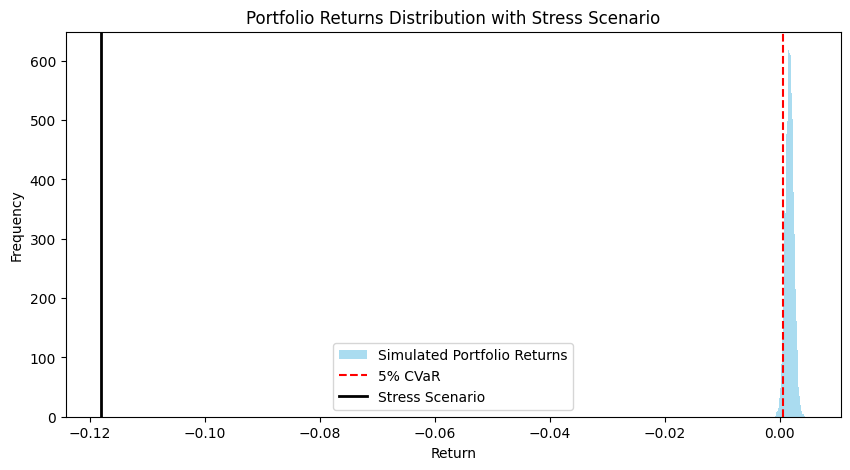

In [14]:
plt.figure(figsize=(10,5))
plt.hist(port_ret, bins=50, alpha=0.7, color='skyblue', label='Simulated Portfolio Returns')
plt.axvline(np.percentile(port_ret, 5), color='red', linestyle='--', label='5% CVaR')
plt.axvline(portfolio_stress_loss, color='black', linestyle='-', linewidth=2, label='Stress Scenario')
plt.title("Portfolio Returns Distribution with Stress Scenario")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()